In [1]:
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

from scipy import stats

from sklearn import datasets

import sys 
sys.path.append("../")
from KDG import KDG

import openml

Using TensorFlow backend.


# Experiment Parameters

In [2]:
max_depth = 30
n_estimators = 2
num_trials = 500

# Data Generation

# Construct & Train Network

## Keurnal Networks

In [3]:
def train_AKN(X, y):
    X_transform, X, y_transform, y = train_test_split(X, y, test_size = .9)
    #X_transform, y_transform = X, y
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)

    predicted_leaf_ids_across_trees = [keras.utils.to_categorical(np.unique(tree.apply(X), return_inverse = True)[1]) for tree_idx, tree in enumerate(rfc.estimators_)]

    return KDG().fit(X, y, predicted_leaf_ids_across_trees)

In [4]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 40
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
        return np.mean(eces_across_y_vals)

In [5]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean((predicted_posterior[:, y_val] - (y == y_val).astype('int'))**2))
    return np.mean(brier_across_y_vals)

In [6]:
'''
for i in range(1, 100):
    X, y = openml.tasks.get_task(i).get_X_and_y()#datasets.load_iris(return_X_y = True)#
    X, X_test, y, y_test = train_test_split(X, y)
    print("I: {}".format(i))
    print(np.shape(X))
    print(len(np.unique(y)))
'''

'\nfor i in range(1, 100):\n    X, y = openml.tasks.get_task(i).get_X_and_y()#datasets.load_iris(return_X_y = True)#\n    X, X_test, y, y_test = train_test_split(X, y)\n    print("I: {}".format(i))\n    print(np.shape(X))\n    print(len(np.unique(y)))\n'

In [7]:
X, y = openml.tasks.get_task(6).get_X_and_y()
X, y = X[np.where(y < 3)], y[np.where(y < 3)]

In [8]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                   max_depth = max_depth)

    rfc.fit(X, y)
    return rfc.predict_proba(X_test)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n))
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test)

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    return y_proba

In [9]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

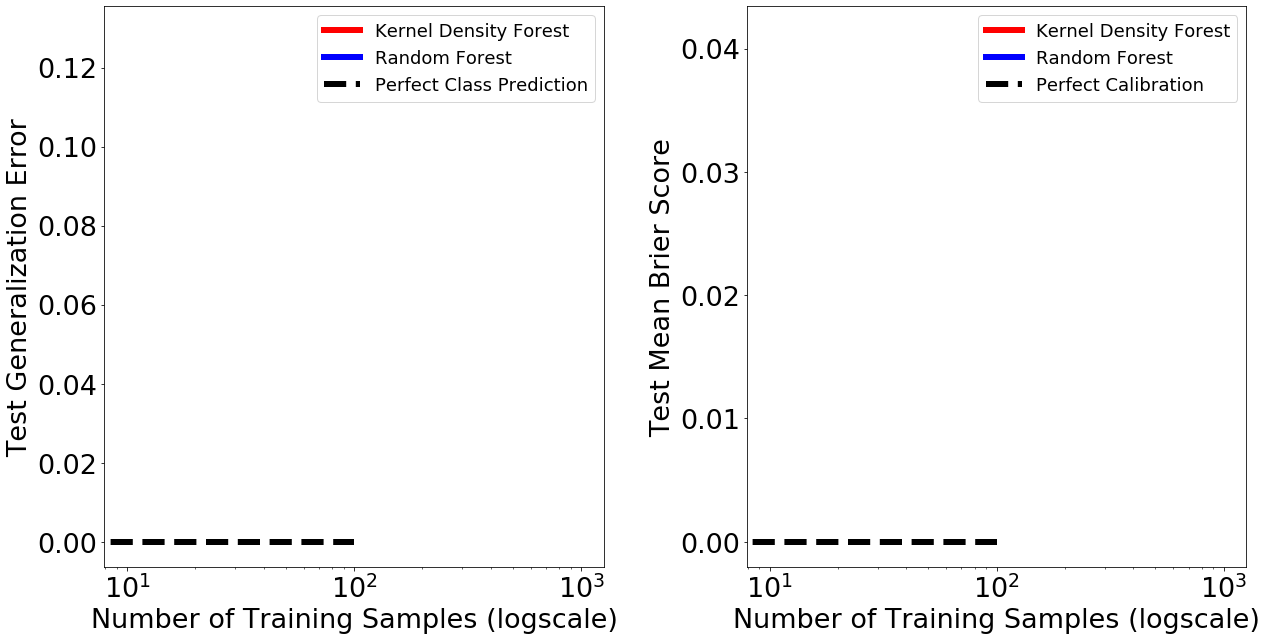

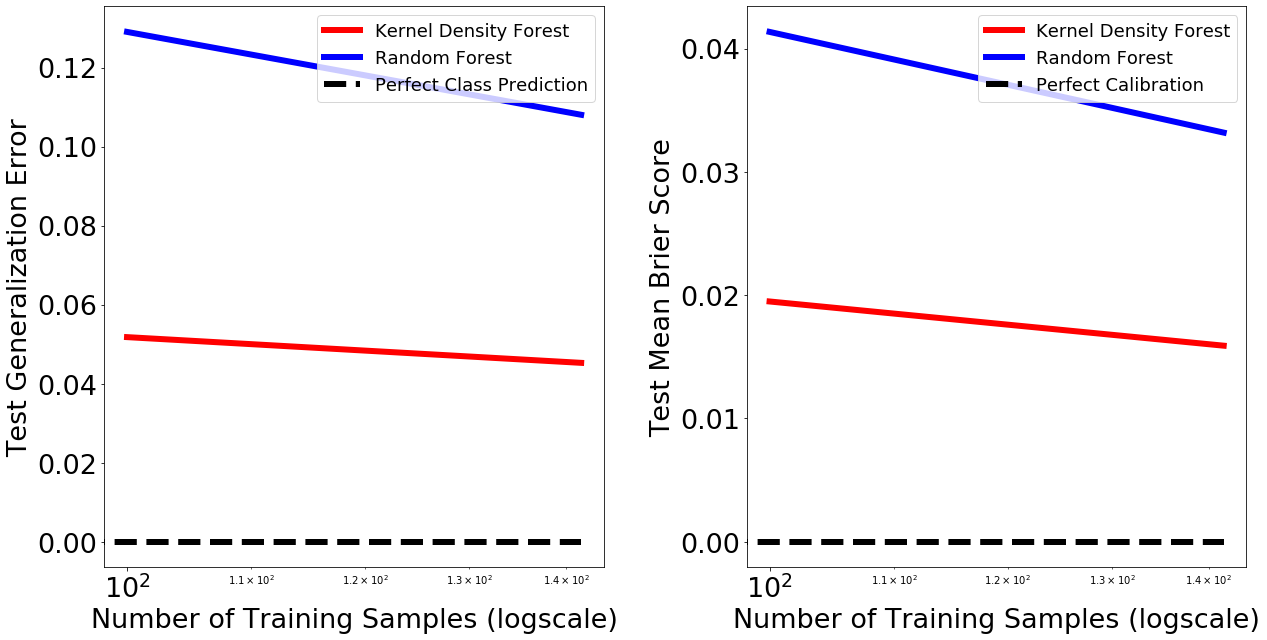

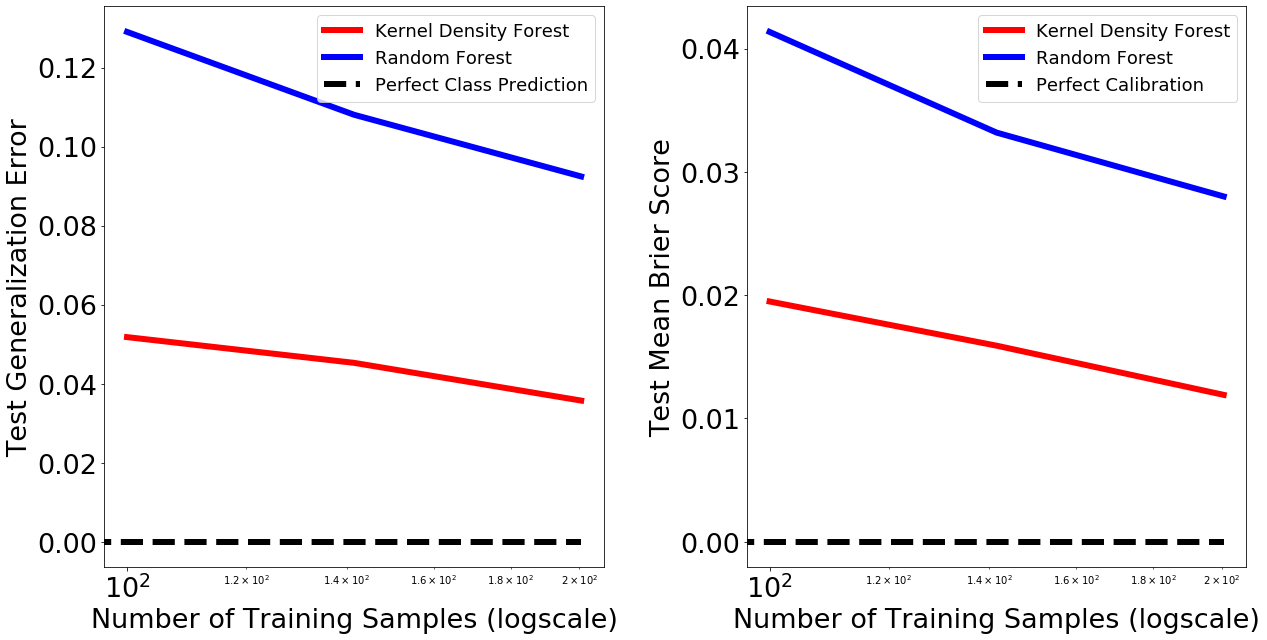

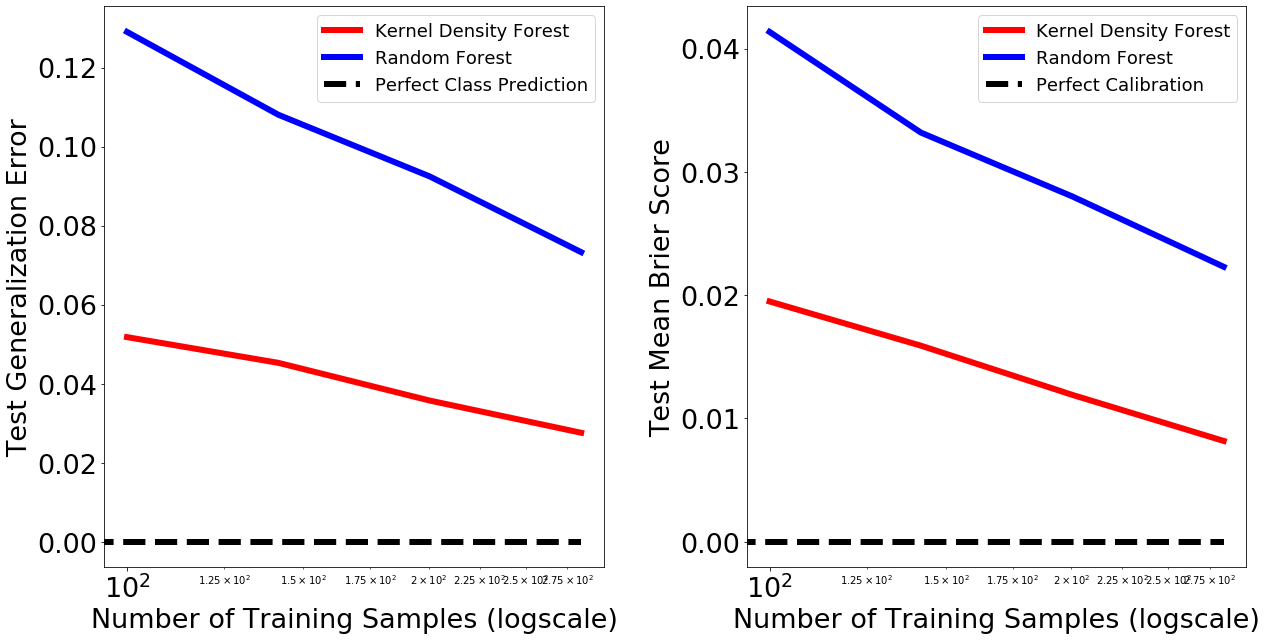

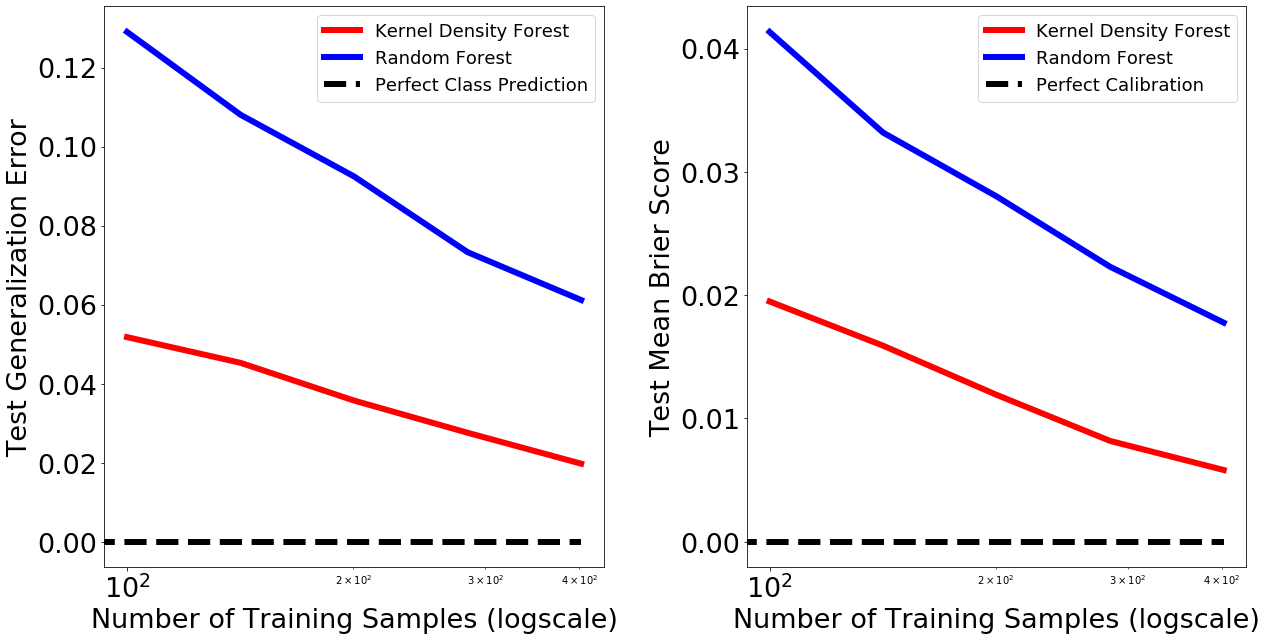

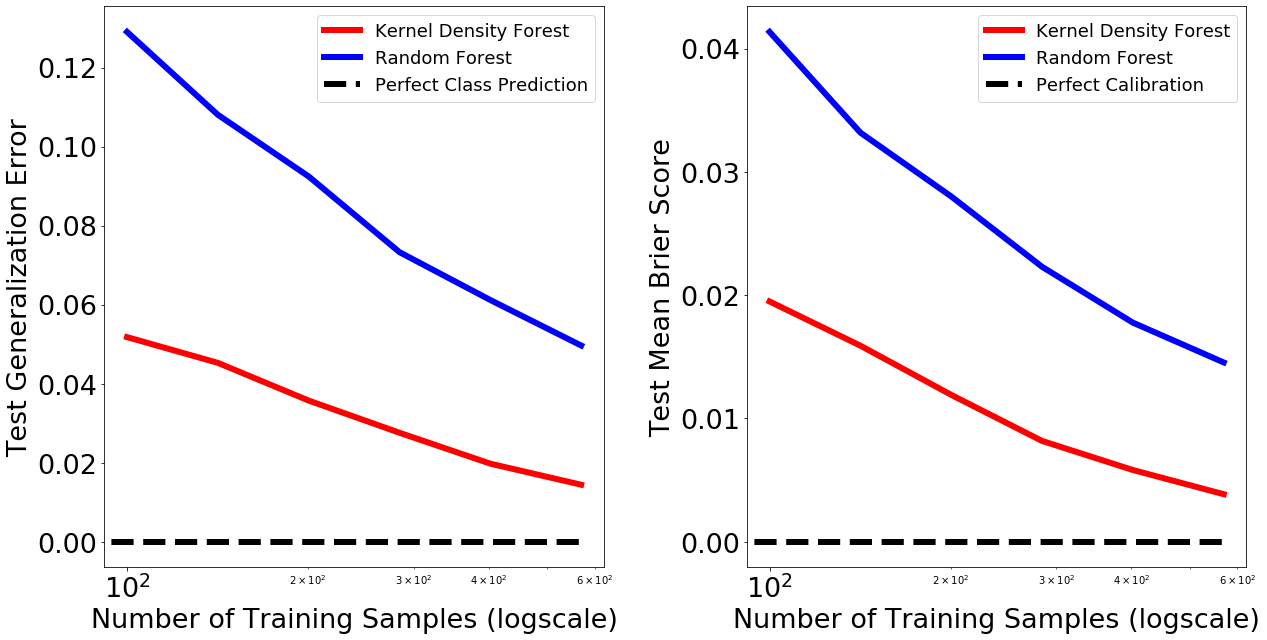

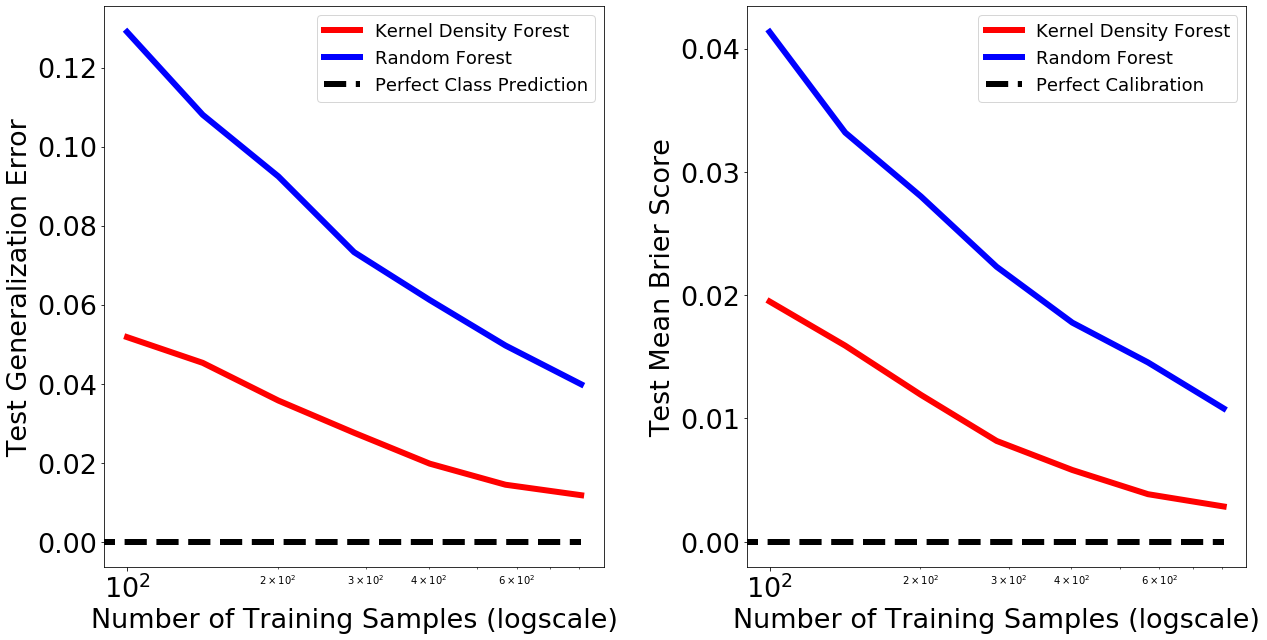

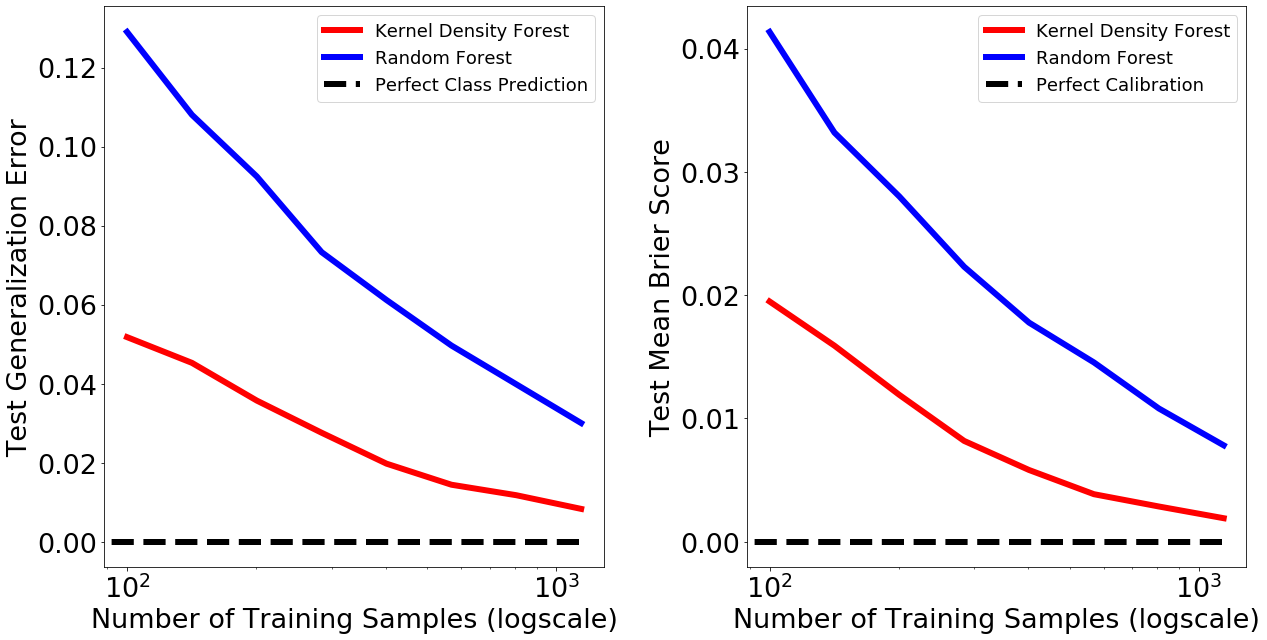

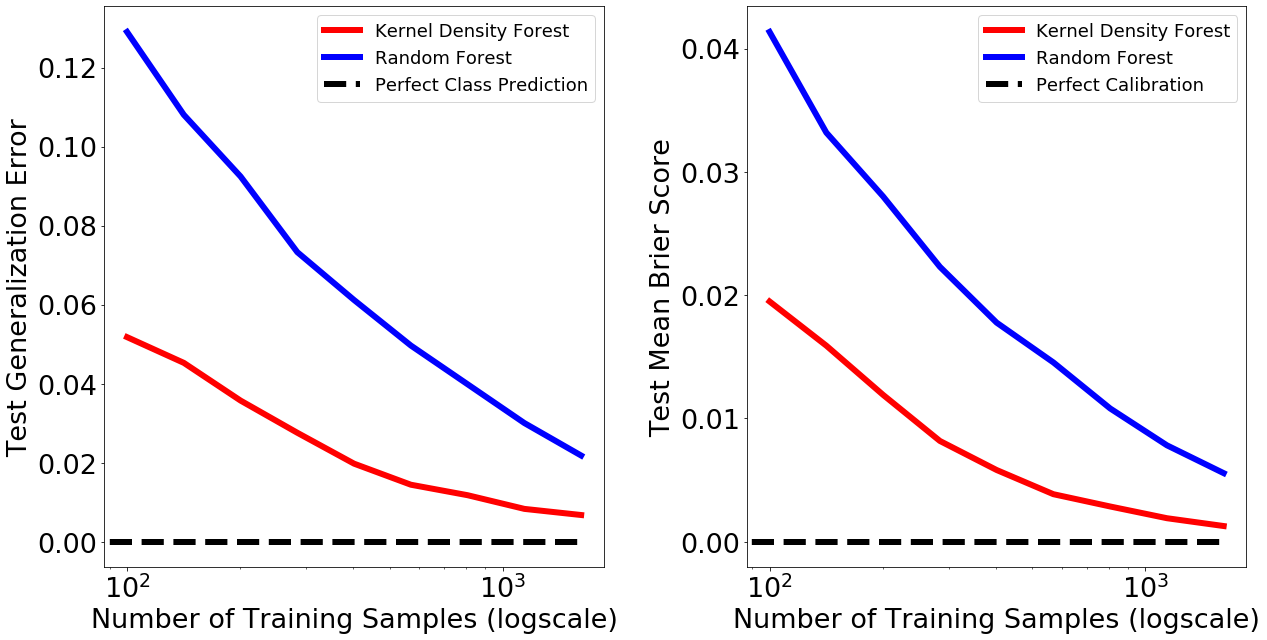

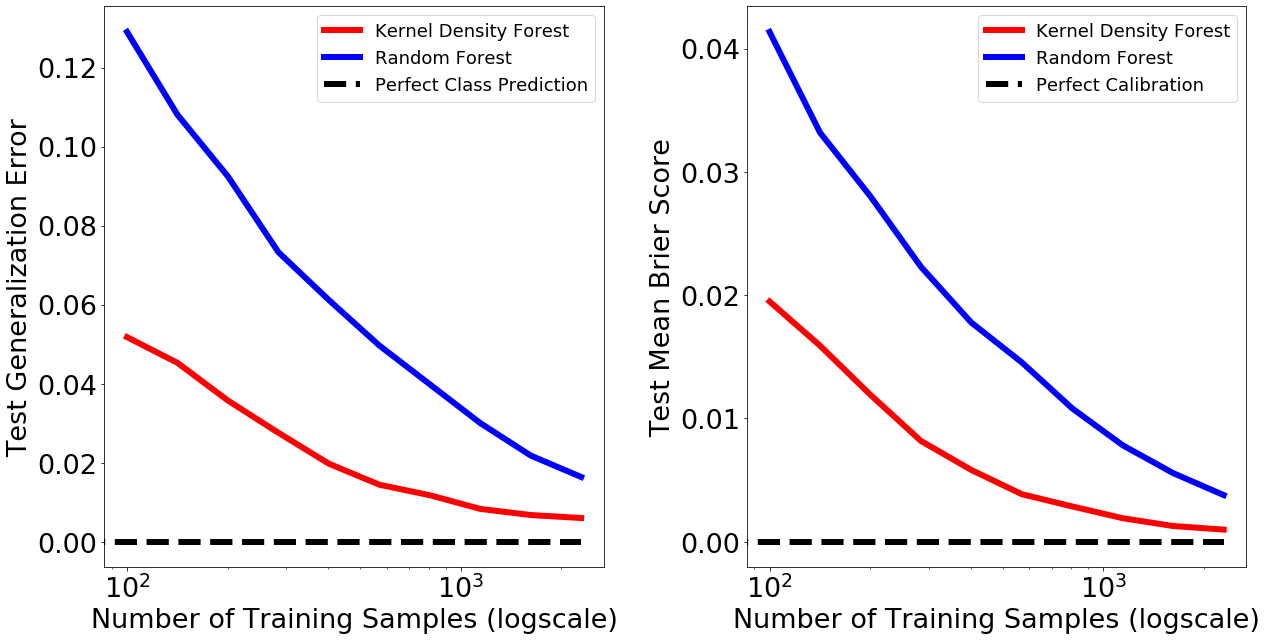

In [12]:
KDE_acc_means = []
network_acc_means = []

KDE_acc_stds = []
network_acc_stds = []

KDE_brier_means = []
network_brier_means = []

KDE_brier_stds = []
network_brier_stds = []
n_ra = np.logspace(2, np.log10(len(X)), num = 10, base = 10)
ticks = np.arange(np.min(n_ra), np.max(n_ra), step = int((np.max(n_ra) - np.min(n_ra)) // 4))
ticks_ra = np.array([int(str(tick)[:1]) * 10 ** int(np.log10(tick)) for tick in ticks])
for n in tqdm(n_ra):
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    KDE_briers_across_trials = []
    network_briers_across_trials = []
    for trial_idx in tqdm(range(num_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        KDE_y_proba = get_KDE_y_proba(X_train, y_train, n, X_test)
        network_y_proba = get_network_y_proba(X, y, n, X_test)
        
        KDE_accs_across_trials.append(np.nanmean(np.argmax(KDE_y_proba, axis = 1) == y_test))
        network_accs_across_trials.append(np.nanmean(np.argmax(network_y_proba, axis = 1) == y_test))
        
        KDE_briers_across_trials.append(get_brier(KDE_y_proba, y_test))
        network_briers_across_trials.append(get_brier(network_y_proba, y_test))
        
    KDE_acc_means.append(clipped_mean(KDE_accs_across_trials))
    network_acc_means.append(clipped_mean(network_accs_across_trials))
    
    KDE_brier_means.append(clipped_mean(KDE_briers_across_trials, low = 0, high = 25))
    network_brier_means.append(clipped_mean(network_briers_across_trials, low = 0, high = 25))

    figs, ax = plt.subplots(1, 2, figsize = (18, 9))
    figs.set_facecolor("white")

    ax[0].tick_params(axis='both', which='major', labelsize=27)
    ax[0].plot(n_ra[:len(KDE_acc_means)] , 1 - np.array(KDE_acc_means), label = "Kernel Density Forest", c = "red")
    ax[0].plot(n_ra[:len(KDE_acc_means)], 1 - np.array(network_acc_means), label = "Random Forest", c = "blue")
    ax[0].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
    ax[0].legend(fontsize = 18, loc = "upper right")
    ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[0].set_ylabel("Test Generalization Error", fontsize = 27)
    ax[0].set_xscale("log")

    ax[1].tick_params(axis='both', which='major', labelsize=27)
    ax[1].plot(n_ra[:len(KDE_acc_means)] , KDE_brier_means, label = "Kernel Density Forest", c = "red")
    ax[1].plot(n_ra[:len(KDE_acc_means)], network_brier_means, label = "Random Forest", c = "blue")
    ax[1].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
    ax[1].legend(fontsize = 18, loc = "upper right")
    ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[1].set_ylabel("Test Mean Brier Score", fontsize = 27)
    ax[1].set_xscale("log")

    figs.tight_layout()

    plt.show()

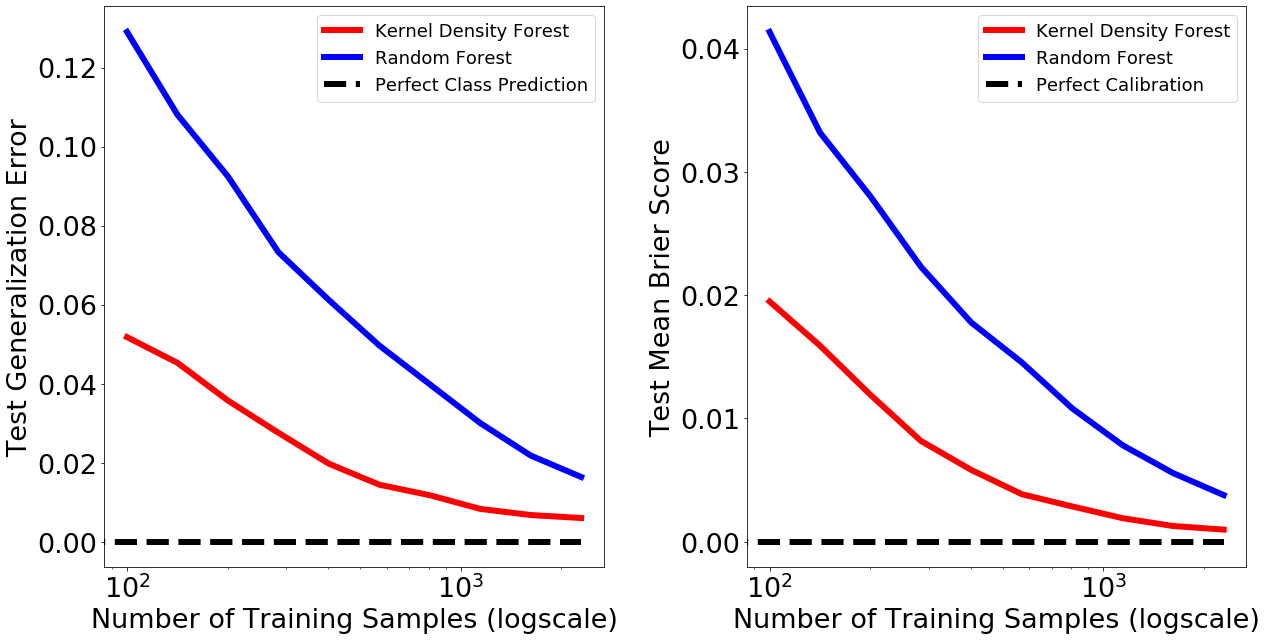

In [13]:
figs, ax = plt.subplots(1, 2, figsize = (18, 9))
figs.set_facecolor("white")

ax[0].tick_params(axis='both', which='major', labelsize=27)
ax[0].plot(n_ra , 1 - np.array(KDE_acc_means), label = "Kernel Density Forest", c = "red")
ax[0].plot(n_ra, 1 - np.array(network_acc_means), label = "Random Forest", c = "blue")
ax[0].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Class Prediction", color = "black")
ax[0].legend(fontsize = 18, loc = "upper right")
ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[0].set_ylabel("Test Generalization Error", fontsize = 27)
ax[0].set_xscale("log")

ax[1].tick_params(axis='both', which='major', labelsize=27)
ax[1].plot(n_ra , KDE_brier_means, label = "Kernel Density Forest", c = "red")
ax[1].plot(n_ra, network_brier_means, label = "Random Forest", c = "blue")
ax[1].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect Calibration", color = "black")
ax[1].legend(fontsize = 18, loc = "upper right")
ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[1].set_ylabel("Test Mean Brier Score", fontsize = 27)
ax[1].set_xscale("log")


figs.tight_layout()

plt.show()